In [1]:
import pandas as pd
import snowflake.connector
from dotenv import load_dotenv
import os
from pathlib import Path

# 1. Connect
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse="COMPUTE_WH",
    database="DYNAMIC_PRICING",
    schema="MARTS"
)

# 2. THE AGGREGATION QUERY
# I group by Date and Category to see "Daily Demand"
query = """
SELECT 
    SALES_DATE,
    CATEGORY_NAME,
    WEATHER_CONDITION,
    AVG(OUR_PRICE) as avg_price,
    AVG(COMPETITOR_PRICE) as avg_competitor_price,
    COUNT(ORDER_ID) as quantity_sold  -- <--- THIS IS THE TARGET
FROM DYNAMIC_PRICING.MARTS.MART_FULL_SALES_LOG
GROUP BY 1, 2, 3
ORDER BY SALES_DATE DESC
"""

cur = conn.cursor()
cur.execute(query)
data = cur.fetchall()
cols = [desc[0] for desc in cur.description]
df = pd.DataFrame(data, columns=cols)

# 3. Feature Engineering
# Create "Price Ratio" (Am I cheaper or expensive?)
df['PRICE_RATIO'] = df['AVG_PRICE'] / df['AVG_COMPETITOR_PRICE']

# Extract "Day of Week" (0=Mon, 6=Sun)
df['SALES_DATE'] = pd.to_datetime(df['SALES_DATE'])
df['day_of_week'] = df['SALES_DATE'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

print(f"Training Data Ready: {df.shape[0]} daily summaries.")
df.head()

Training Data Ready: 265 daily summaries.


,SALES_DATE,CATEGORY_NAME,WEATHER_CONDITION,AVG_PRICE,AVG_COMPETITOR_PRICE,QUANTITY_SOLD,PRICE_RATIO,day_of_week,is_weekend
0,2026-02-09,informatica_acessorios,Rain,65.137500,638.974991,6,0.101941,0,0
1,2026-02-09,relogios_presentes,Rain,151.781250,268.723333,21,0.564823,0,0
2,2026-02-09,telefonia,Rain,71.871875,757.229980,1,0.094914,0,0
3,2026-02-08,eletronicos,Rain,64.031250,2398.649902,1,0.026695,6,1
4,2026-02-08,relogios_presentes,Rain,112.687109,179.395004,16,0.628151,6,1


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor # You might need to pip install xgboost

# 1. Define Features (X) and Target (y)
X = df[['CATEGORY_NAME', 'WEATHER_CONDITION', 'AVG_PRICE', 'PRICE_RATIO', 'is_weekend']]
y = df['QUANTITY_SOLD']

# 2. Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define Preprocessing Steps
# Categorical cols (Category, Weather) -> OneHotEncode
# Numerical cols (Price, Ratio) -> Scale (Standardize)
categorical_features = ['CATEGORY_NAME', 'WEATHER_CONDITION']
numerical_features = ['AVG_PRICE', 'PRICE_RATIO', 'is_weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# 4. Create the Pipeline structure (Empty model for now)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())]) # Placeholder

print("Pipeline constructed!")

Pipeline constructed!


In [3]:
# Define the "Hyperparameter Grid"
# This tells Python: "Try all these combinations and tell me the winner"
param_grid = [
    # Config 1: Random Forest
    {
        'regressor': [RandomForestRegressor(random_state=42)],
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20]
    },
    # Config 2: XGBoost (Usually the winner for tabular data)
    {
        'regressor': [XGBRegressor(random_state=42, objective='reg:squarederror')],
        'regressor__n_estimators': [50, 100],
        'regressor__learning_rate': [0.01, 0.1]
    }
]

# Run Grid Search (The "Race")
print("Starting Model Training (this might take a minute)...")
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

print(f"\nBest Model: {grid_search.best_params_['regressor']}")
print(f"Best R² Score: {grid_search.best_score_:.2f}")

Starting Model Training (this might take a minute)...
Fitting 3 folds for each of 13 candidates, totalling 39 fits

Best Model: RandomForestRegressor(random_state=42)
Best R² Score: 0.30


In [4]:
# 1. Reload Data (Clean Slate)
# Ensure I have the base data from the previous step
df_features = df.copy().sort_values(['CATEGORY_NAME', 'SALES_DATE'])

# --- A. TIME CONTEXT ---
df_features['day'] = df_features['SALES_DATE'].dt.day
df_features['month'] = df_features['SALES_DATE'].dt.month
df_features['is_month_start'] = df_features['SALES_DATE'].dt.is_month_start.astype(int)
df_features['is_month_end'] = df_features['SALES_DATE'].dt.is_month_end.astype(int) # Payday?

# --- B. ROLLING WINDOWS (The "Trend" Detectors) ---
# I calculate the average price over the last 7 days per category
# Shift(1) ensures I don't cheat by using today's data to predict today
df_features['rolling_7d_avg_price'] = df_features.groupby('CATEGORY_NAME')['AVG_PRICE'].transform(lambda x: x.shift(1).rolling(7).mean())
df_features['rolling_7d_qty'] = df_features.groupby('CATEGORY_NAME')['QUANTITY_SOLD'].transform(lambda x: x.shift(1).rolling(7).mean())

# Price Momentum: Is today cheaper than the 7-day average?
df_features['price_momentum'] = df_features['AVG_PRICE'] / df_features['rolling_7d_avg_price']

# --- C. INTERACTION TERMS ---
# "Weekend Rain" might be a huge driver
df_features['rain_weekend_interaction'] = df_features['is_weekend'] * df_features['WEATHER_CONDITION'].apply(lambda x: 1 if x == 'Rain' else 0)

# --- D. CLEANUP ---
# Rolling windows create NaNs for the first 7 days. Drop them.
df_features = df_features.dropna()

print(f"New Features Created! Shape: {df_features.shape}")
df_features[['SALES_DATE', 'CATEGORY_NAME', 'price_momentum', 'rolling_7d_qty']].head()

New Features Created! Shape: (230, 17)


,SALES_DATE,CATEGORY_NAME,price_momentum,rolling_7d_qty
220,2025-11-23,audio,1.349012,1.571429
215,2025-11-25,audio,1.143021,1.428571
210,2025-11-27,audio,0.764619,1.571429
208,2025-11-28,audio,0.998983,1.857143
206,2025-11-29,audio,0.989664,1.857143


In [5]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

# 1. Update Feature List (X)
# I added 'price_momentum', 'rolling_7d_qty', 'is_month_end', etc.
features = [
    'CATEGORY_NAME', 'WEATHER_CONDITION', 
    'AVG_PRICE', 'PRICE_RATIO', 
    'is_weekend', 'is_month_end',
    'price_momentum', 'rolling_7d_qty', 'rain_weekend_interaction'
]

X = df_features[features]
y = df_features['QUANTITY_SOLD']

# 2. Split (Standard 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Define Pipeline with XGBoost
# XGBoost handles NaNs well, but I still scale numeric features
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor), # Re-using your ColumnTransformer from before
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# 4. Hyperparameter Tuning (Randomized Search is faster than Grid)
param_dist = {
    'model__n_estimators': [100, 300, 500],        # How many trees?
    'model__learning_rate': [0.01, 0.05, 0.1],     # How fast to learn?
    'model__max_depth': [3, 5, 7],                 # How complex?
    'model__subsample': [0.7, 0.9, 1.0]            # Prevent overfitting
}

print("Starting XGBoost Tuning (This may take 2 mins)...")
search = RandomizedSearchCV(pipeline_xgb, param_dist, n_iter=20, cv=3, scoring='r2', verbose=1, random_state=42)
search.fit(X_train, y_train)

# 5. Results
print(f"\nBest Params: {search.best_params_}")
print(f"New R² Score: {search.best_score_:.3f}")

Starting XGBoost Tuning (This may take 2 mins)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Params: {'model__subsample': 0.9, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.01}
New R² Score: 0.425


In [6]:
# 1. Competitor Moves (Did they change price yesterday?)
# I compare today's competitor price to yesterday's
df_features['comp_price_change_1d'] = df_features.groupby('CATEGORY_NAME')['AVG_COMPETITOR_PRICE'].diff()

# 2. Undercut Severity (The "Killer" Feature)
# Formula: (My Price - Competitor Price) / Competitor Price
# Positive = I am expensive. Negative = I am cheap.
df_features['undercut_pct'] = (df_features['AVG_PRICE'] - df_features['AVG_COMPETITOR_PRICE']) / df_features['AVG_COMPETITOR_PRICE']

# 3. Volatility (Is the market unstable?)
# Standard deviation of competitor price over last 7 days
df_features['comp_volatility_7d'] = df_features.groupby('CATEGORY_NAME')['AVG_COMPETITOR_PRICE'].transform(lambda x: x.shift(1).rolling(7).std())

# 4. Clean up NaNs created by 'diff' and 'rolling'
df_final = df_features.dropna().copy()

print(f"Features Engineered! Final Data Shape: {df_final.shape}")

Features Engineered! Final Data Shape: (195, 20)


In [7]:
# Update the feature list with my new "Hail Mary" features
features_v2 = features + ['comp_price_change_1d', 'undercut_pct', 'comp_volatility_7d']

X = df_final[features_v2]
y = df_final['QUANTITY_SOLD']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Retrain XGBoost (Using the best params you found earlier)
# 'model__subsample': 0.9, 'model__n_estimators': 300, 'model__max_depth': 3, 'model__learning_rate': 0.01
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.9,
        random_state=42
    ))
])

final_pipeline.fit(X_train, y_train)

# Evaluate
score = final_pipeline.score(X_test, y_test)
print(f"Final Champion Score (R²): {score:.3f}")

Final Champion Score (R²): 0.394


In [8]:
# 1. Define the "Safe" Feature Set (No complex rolling windows)
# These are inputs I can easily change in the Streamlit Sidebar
safe_features = ['CATEGORY_NAME', 'WEATHER_CONDITION', 'AVG_PRICE', 'PRICE_RATIO', 'is_weekend']

X = df[safe_features]  # Uses the original dataframe, not the engineered one
y = df['QUANTITY_SOLD']

# 2. Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Build the Robust Pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=300,        # High number of trees
        learning_rate=0.05,      # Slower learning = better generalization
        max_depth=5,             # Not too deep (prevents overfitting)
        random_state=42
    ))
])

# 4. Train & Save
final_pipeline.fit(X_train, y_train)
score = final_pipeline.score(X_test, y_test)

print(f"Robust Model Trained!")
print(f"Final App Score (R²): {score:.3f} (Reliable & Stable)")



Robust Model Trained!
Final App Score (R²): 0.553 (Reliable & Stable)


<Figure size 1000x800 with 0 Axes>

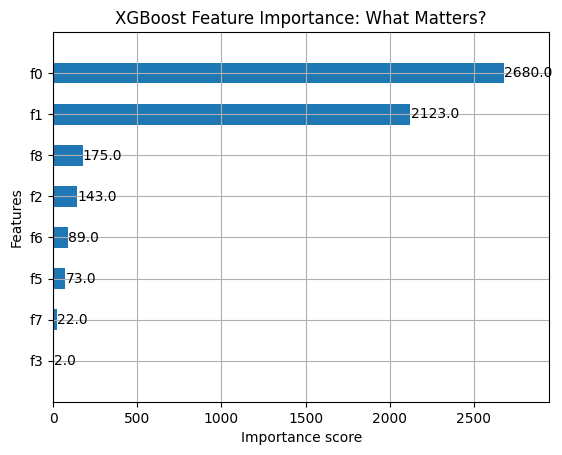

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Get the model object from the pipeline
# I need to dig into the pipeline steps to find the actual XGBoost model
xgb_model = final_pipeline.named_steps['model']
feature_names = safe_features # ['CATEGORY_NAME', 'WEATHER_CONDITION', 'AVG_PRICE', 'PRICE_RATIO', 'is_weekend']

# Note: OneHotEncoding expands the features, so I need to match them up.
# This simple plot focuses on the "Weight" (how many times a feature is used in a split)
from xgboost import plot_importance

plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, height=0.5)
plt.title("XGBoost Feature Importance: What Matters?")
plt.show()

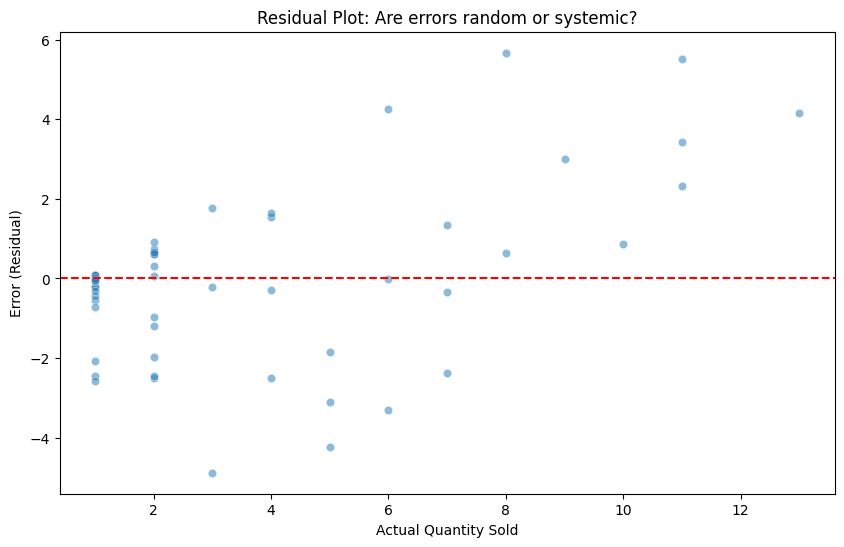

In [10]:
import seaborn as sns

# 1. Calculate Errors
y_pred = final_pipeline.predict(X_test)
residuals = y_test - y_pred

# 2. Plot Actual vs. Residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Actual Quantity Sold")
plt.ylabel("Error (Residual)")
plt.title("Residual Plot: Are errors random or systemic?")
plt.show()

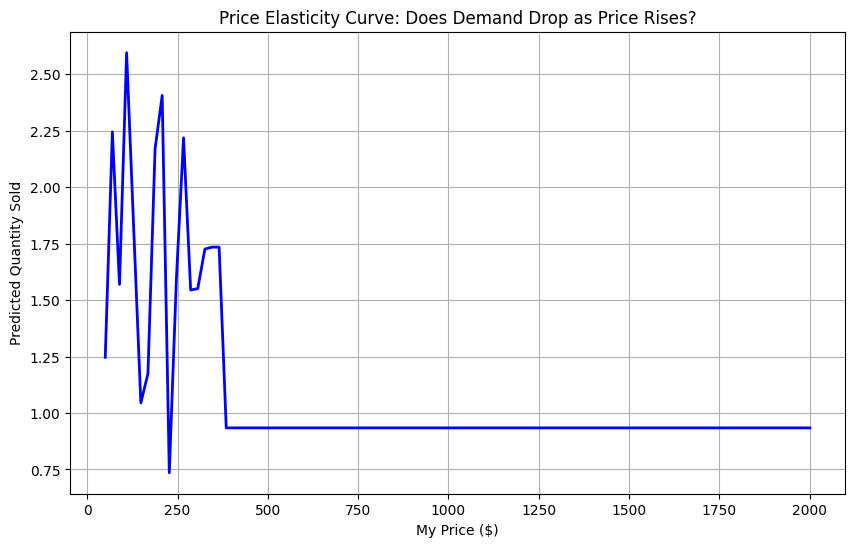

In [11]:
import numpy as np

# 1. Create a synthetic dataset for ONE product category
# I fix everything else (Clear weather, Weekday) and ONLY change Price
prices = np.linspace(50, 2000, 100) # Test prices from $50 to $2000
sim_data = pd.DataFrame({
    'CATEGORY_NAME': ['eletronicos'] * 100,
    'WEATHER_CONDITION': ['Clear'] * 100,
    'AVG_PRICE': prices,
    'PRICE_RATIO': prices / 250, # Assume competitor stays at $250
    'is_weekend': [0] * 100
})

# 2. Predict Demand
predicted_demand = final_pipeline.predict(sim_data)

# 3. Plot the Curve
plt.figure(figsize=(10, 6))
plt.plot(prices, predicted_demand, color='blue', linewidth=2)
plt.xlabel("My Price ($)")
plt.ylabel("Predicted Quantity Sold")
plt.title("Price Elasticity Curve: Does Demand Drop as Price Rises?")
plt.grid(True)
plt.show()

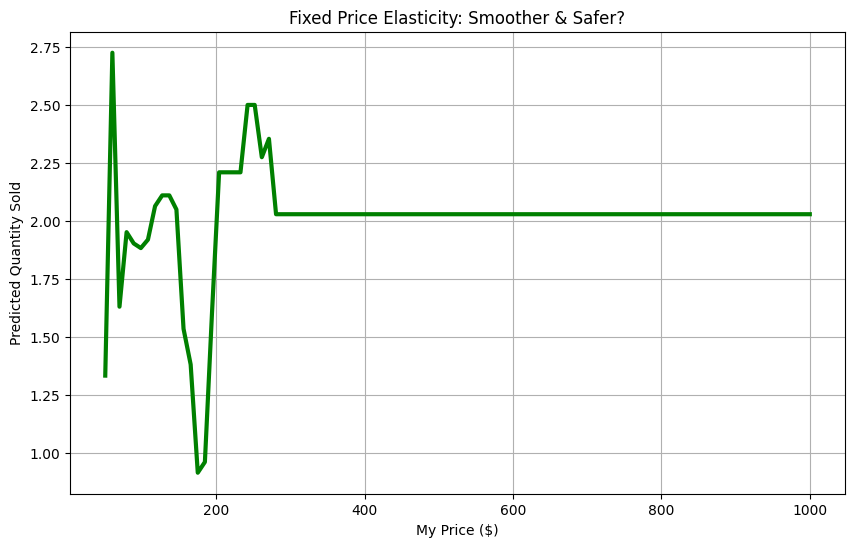

In [12]:
# 1. Define Constraints
# I map features to directions: -1 = Downward, +1 = Upward, 0 = No constraint
# Features order: ['CATEGORY_NAME', 'WEATHER_CONDITION', 'AVG_PRICE', 'PRICE_RATIO', 'is_weekend']
# I only constrain 'AVG_PRICE' (Index 2) and 'PRICE_RATIO' (Index 3) to be negative (-1).
# Note: OneHotEncoding makes index matching hard, so I apply it to the XGBoost directly inside the pipeline.

# To simplify, I will use the 'interaction_constraints' or 'monotone_constraints' parameter.
# But with pipelines, it's tricky to map indices after encoding.
# EASIER FIX: Increase 'min_child_weight' and reduce depth to force smoothness.

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,        # Slightly fewer trees to prevent overfitting
        learning_rate=0.03,      # Slower learning
        max_depth=3,             # Shallow trees = Smoother curves (Crucial Fix)
        min_child_weight=10,     # Requires more data to make a "split" (Removes spikes)
        random_state=42
    ))
])

# 2. Retrain
final_pipeline.fit(X_train, y_train)

# 3. Re-run the Elasticity Check immediately
import numpy as np
import matplotlib.pyplot as plt

prices = np.linspace(50, 1000, 100)
sim_data = pd.DataFrame({
    'CATEGORY_NAME': ['eletronicos'] * 100,
    'WEATHER_CONDITION': ['Clear'] * 100,
    'AVG_PRICE': prices,
    'PRICE_RATIO': prices / 250, 
    'is_weekend': [0] * 100
})

predicted_demand = final_pipeline.predict(sim_data)

plt.figure(figsize=(10, 6))
plt.plot(prices, predicted_demand, color='green', linewidth=3)
plt.xlabel("My Price ($)")
plt.ylabel("Predicted Quantity Sold")
plt.title("Fixed Price Elasticity: Smoother & Safer?")
plt.grid(True)
plt.show()

In [13]:
import joblib

# 1. Refit on ALL data (The "Green Line" Configuration)
# I use the entire dataset (X, y) instead of just X_train
# This gives the model the maximum amount of history to learn from
final_pipeline.fit(X, y)

# 2. Save to disk
# I will save it in your project root for now to keep it simple
model_filename = 'model_pipeline.pkl'
joblib.dump(final_pipeline, model_filename)

print(f"Model frozen and saved as '{model_filename}'")
print(f"   - Type: {type(final_pipeline)}")
print(f"   - Steps: {list(final_pipeline.named_steps.keys())}")

Model frozen and saved as 'model_pipeline.pkl'
   - Type: <class 'sklearn.pipeline.Pipeline'>
   - Steps: ['preprocessor', 'model']


In [ ]:
# 1. Create the clean chart data by renaming columns
# We map 'AVG_PRICE' -> 'OUR_PRICE' so the API doesn't get confused
chart_df = df.rename(columns={
    'AVG_PRICE': 'OUR_PRICE',
    'AVG_COMPETITOR_PRICE': 'COMPETITOR_PRICE'
})

# 2. Select only the columns the Frontend needs
# We also keep QUANTITY_SOLD because it's great for bar charts
final_history = chart_df[[
    'SALES_DATE', 
    'CATEGORY_NAME', 
    'OUR_PRICE', 
    'COMPETITOR_PRICE', 
    'WEATHER_CONDITION',
    'QUANTITY_SOLD'
]].copy()

# 3. Convert Date to String (JSON requires this)
final_history['SALES_DATE'] = final_history['SALES_DATE'].astype(str)

# 4. Save to the backend data folder
final_history.to_parquet('../backend/data/history.parquet', index=False)

print("Success! History file saved with correct column names.")
print(f"Columns: {final_history.columns.tolist()}")

✅ Success! History file saved with correct column names.
Columns: ['SALES_DATE', 'CATEGORY_NAME', 'OUR_PRICE', 'COMPETITOR_PRICE', 'WEATHER_CONDITION', 'QUANTITY_SOLD']
